# Computing traveltime/slowness derivatives with respect to CMB radius deviations

In order to go from traveltime deviations to deviations in CMB topography, we need to know how the traveltime is affected by a given deviation in the radius of the CMB at the bouncepoint.  (This make a linearising assumption that the bouncepoint is the same, and we are also assuming that the traveltime perturbations are also linearly related to CMB radius at that point.)

For now, I have decided against rewriting ObsPy to allow us to do this without creating text files describing the Earth velocity/density models; instead we will base ourselves on iasp91 and vary the CMB radius a bit either way, and compute the change in traveltime therefrom.

## Installation

Assuming you are using MacPorts, the following will get you to this stage:

`$ sudo port install python27 py27-ipython py27-numpy py27-obspy`

## How to change the model when changing the CMB radius

There are a number of ways we could change our model when changing the CMB radius:
 1. 'Consume' the layers of the mantle above, so the mantle velocity at the CMB changes, but remains the same as in the original model for this new CMB depth
 2. 'Stretch/squash' the layers of the mantle above, so the mantle velocity at the CMB is the same, but the rest of the model changes
 3. Hybrid of the previous two, where we stretch/squash the mantle above, but only up to some radius above the CMB.

Option 1 might be physical, or might not, but is practically the hardest at this instant because we need to do more manual twiddling of the model in Python (splitting up layers and so on).

Option 2 isn't really desirable because the whole Earth model will change and affect everything, including the location of the mantle discontinuities.  This will have a large effect on both P and PcP, and isn't justified by what we think we know about CMB topography.

In the rest of this we will employ method 3, stretching the bottom layer of the model only.

## Creating an Earth model file in Python

It turns out to easily modify a builtin model in the distance-velocity domain, rather than the tau-p domain, we need to begin right at the beginning, reading in the layered velocity model.  These are stored as 'tvel'-format files.

We can get the list of installed tvel files with the get_builtin_tvel_files() function:

In [1]:
import obspy.taup
import numpy as np
# Only run this in the notebook and let us use the function by importing this file
if __name__ == "__main__":
    tvel_files = obspy.taup.taup_create.get_builtin_tvel_files()
    print tvel_files

[u'/Users/nowacki/Applications/ObsPy/obspy/taup/data/ak135.tvel', u'/Users/nowacki/Applications/ObsPy/obspy/taup/data/iasp91.tvel']


Let's choose the iasp91 file:

In [2]:
    file = tvel_files[1]

ObsPy defines some functions to read in a tvel file and look at its contents, so read in the model file:

In [3]:
    model = obspy.taup.velocity_model.VelocityModel.readVelocityFile(file)
    print "CMB depth =", model.cmbDepth, "km for model file ", file

CMB depth = 2889.0 km for model file  /Users/nowacki/Applications/ObsPy/obspy/taup/data/iasp91.tvel


Note the CMB is at 2889.0.  We can perturb this manually, and then use this model file to create a TauPy model.

In [4]:
    icmb = model.layerNumberAbove(model.cmbDepth)
    # layerNumberAbove returns an array
    icmb = icmb[0]
    print model.layers[icmb]
    print model.layers[icmb+1]
    # Fields are: depth to top of layer, depth to bottom of layer, Vp at top, Vp at bottom,
    #             Vs at top, Vs at bottom, rho at top, rho at bottom, Qp at top, Qp at bottom, Qs at top, Qs at bottom

(2839.33, 2889.0, 13.6793, 13.6908, 7.2892, 7.3015, 5.5284, 5.5515, 1000.0, 1000.0, 2000.0, 2000.0)
(2889.0, 2939.33, 8.0088, 8.0963, 0.0, 0.0, 9.9145, 9.9942, 1000.0, 1000.0, 2000.0, 2000.0)


In [5]:
    # Create two models, one with and one without CMB perturbation
    model_perturb = obspy.taup.velocity_model.VelocityModel.readVelocityFile(file)
    # CMB warped upwards by 5 km
    dc = 5
    model_perturb.layers[icmb][1] -= dc
    model_perturb.layers[icmb+1][0] -= dc
    print model_perturb.layers[icmb]
    print model_perturb.layers[icmb+1]

(2839.33, 2884.0, 13.6793, 13.6908, 7.2892, 7.3015, 5.5284, 5.5515, 1000.0, 1000.0, 2000.0, 2000.0)
(2884.0, 2939.33, 8.0088, 8.0963, 0.0, 0.0, 9.9145, 9.9942, 1000.0, 1000.0, 2000.0, 2000.0)


So, we now have two models, one with and one without a perturbation to the CMB.  Using these velocity models, we can create slowness models, which can be turned into TauPy classes (tau-p models), and then calculate everything else we need to know:

In [7]:
    #TODO: The first time this is run, a warning is returned, but the model is still created.
    #      This needs investigating, but agrees with the expected results.
    smodel = obspy.taup.slowness_model.SlownessModel(model)
    smodel_perturb = obspy.taup.slowness_model.SlownessModel(model_perturb)
    tpmodel = obspy.taup.tau_model.TauModel(smodel)
    tpmodel_perturb = obspy.taup.tau_model.TauModel(smodel_perturb)

Using the tau-p models (tpmodel, tpmodel_perturb), get the travel times:

In [8]:
    m = obspy.taup.TauPyModel()
    m_perturb = obspy.taup.TauPyModel()
    m.model = tpmodel
    m_perturb.model = tpmodel_perturb
    depth = 100
    distance = 90
    arr = m.get_travel_times(depth, distance, phase_list=['PcP', 'P'])
    arr_perturb = m_perturb.get_travel_times(depth, distance, phase_list=['PcP', 'P'])
    print arr
    print arr_perturb
    print "Difference due to", dc, "km upward deflection at", distance, "degrees for an event at", depth, \
        "km is", arr_perturb[1].time - arr[1].time, "s"

2 arrivals
	P phase arrival at 768.164 seconds
	PcP phase arrival at 769.169 seconds
2 arrivals
	P phase arrival at 768.164 seconds
	PcP phase arrival at 769.109 seconds
Difference due to 5 km upward deflection at 90 degrees for an event at 100 km is -0.0598909290527 s


## Making it into a function

Instead of all those steps, let's allow us to go from a file to a TauPyModel in one go, with a function requiring only the CMB perturbation:

In [9]:
def get_iasp91_cmb_perturbed_model(dc):
    """
    Return a perturbed version of the inbuilt iasp91 model, where the CMB is shifted
    up or down by dc km.  Positive values shift the CMB up, and squash the bottom layer in
    iasp91 so that the velocity at the CMB is the same when the CMB is perturbed.
    Arguments:
        dc : Perturbation to the CMB depth / km.  Positive dc is towards the surface.
    Returns a TauPyModel instance.
    """
    import os
    import glob
    import sys
    from obspy.taup.taup_create import __DATA_DIR
    # Find inbuilt model file for iasp91, called iasp91.tvel
    tvel_files = glob.glob(os.path.join(__DATA_DIR, "iasp91.tvel"))
    if len(tvel_files) != 1:
        sys.stdout.write("get_iasp91_cmb_perturbed_model: Error: Cannot find iasp91.tvel file")
        sys.exit(1)
    file = tvel_files[0]
    # Create velocity model from this
    model = obspy.taup.velocity_model.VelocityModel.readVelocityFile(file)
    # Perturb bottom layer
    icmb = model.layerNumberAbove(model.cmbDepth)[0]
    model.layers[icmb][1] -= dc
    model.layers[icmb+1][0] -= dc
    # Create slowness model from velocity model
    smodel = obspy.taup.slowness_model.SlownessModel(model)
    # Create tau-p model from slowness model
    tpmodel = obspy.taup.tau_model.TauModel(smodel)
    # Create new instance of TauPyModel class, and replace it with the perturbed one
    m = obspy.taup.TauPyModel()
    m.model = tpmodel
    return m

## Using the function to construct dt-dc curves

We now have a sensible way to create models and compute the difference in traveltime we expect for a given change in the radius of the CMB, assuming the velocities in the bottom layer of the model are stretched to have the same minimum and maximum.

Let's create a curve for a few different distance ranges showing how traveltimes vary with changes in the CMB radius.

*This will take quite a few seconds*

In [10]:
if __name__ == "__main__":
    # Model against which we compare
    iasp91 = obspy.taup.TauPyModel("iasp91")
    # Event parameters
    depth = 100.
    distances = np.array([30., 55., 80.])
    nd = len(distances)
    dcs = np.arange(-15., 16., 5.)
    ndc = len(dcs)
    # Array holding the traveltimes, with dimensions (distance, dc)
    dt = np.zeros([nd, ndc])
    for idc in range(ndc):
        dc = dcs[idc]
        # Create model for this deflection
        m = get_iasp91_cmb_perturbed_model(dc)
        for id in range(nd):
            d = distances[id]
            arr_iasp91 = iasp91.get_travel_times(depth, d, phase_list=['P', 'PcP'])
            arr = m.get_travel_times(depth, d, phase_list=['P', 'PcP'])
            dt[id,idc] = arr[1].time - arr_iasp91[1].time

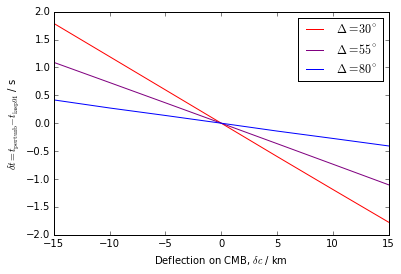

In [11]:
    %matplotlib inline
    import matplotlib.pyplot as plt
    dt_30deg = dt[0,:]
    dt_55deg = dt[1,:]
    dt_80deg = dt[2,:]
    p = plt.plot(dcs, dt_30deg, color='red', label=r"$\Delta = 30^\circ$")
    p = plt.plot(dcs, dt_55deg, color='purple', label=r"$\Delta = 55^\circ$")
    p = plt.plot(dcs, dt_80deg, color='blue', label=r"$\Delta = 80^\circ$")
    plt.xlabel(r"Deflection on CMB, $\delta c$ / km")
    plt.ylabel(r"$\delta t = t_\mathrm{perturb} - t_\mathrm{iasp91}$ / s")
    plt.legend()
    plt.show()

## Conclusions

It's slow, but it works, and it only needs to be done once.  It seems clear that for differences in CMB radius of up to 15 km, the traveltime perturbation in PcP is very close to linear.  We can therefore construct travel time tables for earthquake depth, epicentral distance and CMB deflection, and optionally fit an analytical surface describing the derivatives.

### Further work
- Try doing the same, but applying option 1 above; i.e., consume the mantle rather than stretch the layers.  This will not have a large effect, since the velocity variation over the last layer in the mantle in iasp91 is 0.08 %.
- Clean up the code to handle errors better.
- Allow larger perturbations: this will involve improving our method of modifying the velocity models so that we can consume/stretch an arbitrary number of model layers.  Whether or not this invalidated the linearising assumptions behind computing the derivatives in the first place is another matter.